<a href="https://colab.research.google.com/github/zubaidah93/hello-world/blob/master/ripeYAY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Done converting
[INFO] .DS_Store files removed
[INFO] Files and directories in ./. 
['Tomato Ripe', 'Tomato Yellow', 'Tomato not Ripened', 'Not Classified']
[INFO] Loading images ...
('[INFO] Loading', 'Tomato Ripe')
('[INFO] Loading', 'Tomato Yellow')
('[INFO] Loading', 'Tomato not Ripened')
('[INFO] Loading', 'Not Classified')
[INFO] Image loading completed
[INFO] Transform the loaded training image data into numpy array Complete
('Total number of images: ', 371)
('Total number of classes: ', 4)
[INFO] Splitting data to train and test...
[INFO] Summay of creating a sequential model and adding layers at the appropriate positions
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 26, 26, 32)        896       
_____________

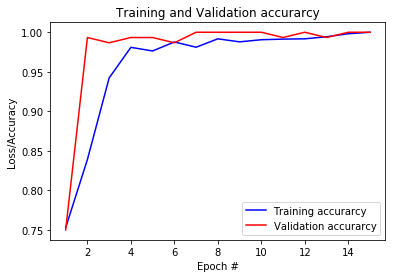

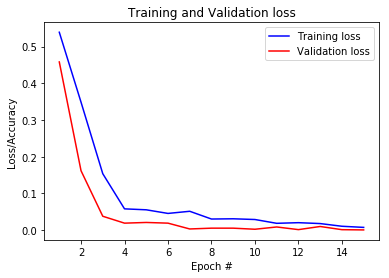

[INFO] Calculating model accuracy
75/75 [==============================] - 0s 612us/step
('Test accuracy = ', 100.0)
[INFO] Saving model...
[INFO] Saving label transform...
Tomato Ripe


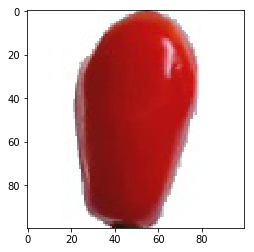

In [12]:
#connect google drive in Colab
from google.colab import drive
drive.mount('/content/drive')

#import libraries

import numpy as np
import cPickle as pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from threading import Thread 
from tensorflow.python.keras import losses
import sklearn.metrics as metrics
#########################################


# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((28, 28))
# Number of images used to train the model
N_IMAGES = 100

# Path to the dataset folder
root_dir = './drive/MyDrive/Ripeness/dataset'

train_dir = os.path.join(root_dir, 'Training')
val_dir = os.path.join(root_dir, 'Test')

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print("Error : {e}")
        return None 

print("Done converting")

image_list, label_list = [], []

try:
    
    plant_disease_folder_list = listdir(train_dir)
    for directory in train_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            train_dir.remove(directory)
    print("[INFO] .DS_Store files removed")
  
    print("[INFO] Files and directories in ./. ")  
    print(plant_disease_folder_list)
    print("[INFO] Loading images ...")

    for plant_disease_folder in plant_disease_folder_list:

      plant_disease_image_list = listdir(train_dir+'/'+plant_disease_folder)
      
      for image in plant_disease_image_list[:N_IMAGES]:
          image_directory = train_dir+'/'+plant_disease_folder+'/'+image
          if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
               image_list.append(convert_image_to_array(image_directory))
               label_list.append(plant_disease_folder)
      print('[INFO] Loading',plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception, e:
    print("Error :",e)
# Transform the loaded training image data into numpy array

np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print('[INFO] Transform the loaded training image data into numpy array Complete')

# Check the number of images loaded for training
image_len = len(image_list)
print("Total number of images: ", image_len)

#check the number of classes 


label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('/content/drive/MyDrive/Ripeness/plant_ripeness_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 1, stratify=image_labels)


#Build Model

#Creating a sequential model and adding Convolutional, Normalization, Pooling, Dropout and Activation layers at the appropriate positions.
EPOCHS = 15
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 28
HEIGHT = 28
DEPTH = 3

print("[INFO] Summay of creating a sequential model and adding layers at the appropriate positions")


inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1
model = Sequential()
#input layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=inputShape))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()
#############################################

#Train Model

# Initialize optimizer
opt = Adam(lr=LR, decay=LR / EPOCHS)

#tf.keras.losses.BinaryCrossentropy(
  #  from_logits=False, label_smoothing=0, reduction="auto", name="binary_crossentropy"
#)
#binary_crossentropy=tf.keras.losses.BinaryCrossentropy()
# Compile model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train model
print("[INFO] Training network...")
history = model.fit_generator(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_test, y_test),
                              steps_per_epoch=len(x_train) // BATCH_SIZE,
                              epochs=EPOCHS, 
                              verbose=1)

#Evaluate model

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

#accuracy evaluation

print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print("Test accuracy = ", (scores[1]*100))

#######################################

print("[INFO] Saving model...")

model.save("/content/drive/MyDrive/Ripeness/ripeness.h5")

print("[INFO] Saving label transform...")
filename = '/content/drive/MyDrive/Ripeness/plant_ripeness_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

###############################
true_classes= 
#Test_Model
def predict_ripeness(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result= np.argmax(model.predict(np_image), axis=-1)
    #result = model.predict_classes(np_image)
    print((image_labels.classes_[result][0]))
  
predict_ripeness('/content/drive/MyDrive/Ripeness/dataset/Test/Tomato Ripe/105_100.jpg')
  


Tomato Yellow


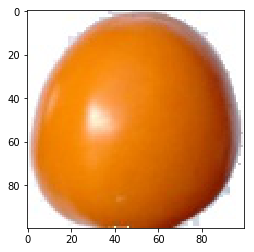

In [13]:
predict_ripeness('/content/drive/MyDrive/Ripeness/dataset/Test/Tomato Yellow/104_100.jpg')

Tomato not Ripened


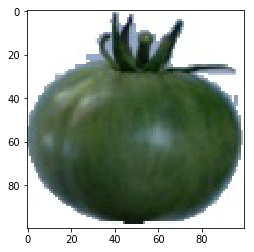

In [14]:
predict_ripeness('/content/drive/MyDrive/Ripeness/dataset/Test/Tomato not Ripened/148_100.jpg')

Not Classified


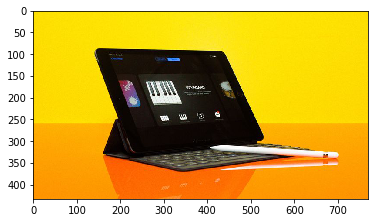

In [16]:
predict_ripeness('/content/drive/MyDrive/Ripeness/dataset/Test/Not Classified/11-ipad-2019-10-2.jpg')

Tomato Ripe


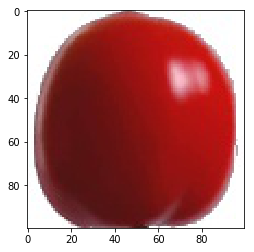

In [18]:
predict_ripeness("/content/drive/MyDrive/Ripeness/dataset/Test/Tomato Ripe/133_100.jpg")

Tomato Ripe


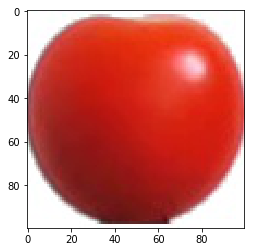

In [17]:
predict_ripeness("/content/drive/MyDrive/Ripeness/dataset/Test/Tomato Ripe/281_100.jpg")